In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Casino HMM example

In [17]:
T = 100
N = 2  # Number of states (fair and unfair)

# Given die probabilities
FAIR_PROBS = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
UNFAIR_PROBS = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])  # Example: biased towards 6

initial_probs = np.array([0.5, 0.5])

# Given transition probabilities
P_STAY_FAIR = 0.95
P_STAY_UNFAIR = 0.8


transition_matrix = np.array([[P_STAY_FAIR, 1-P_STAY_FAIR],
                                  [1-P_STAY_UNFAIR, P_STAY_UNFAIR]])
emission_matrix = np.vstack((FAIR_PROBS, UNFAIR_PROBS))

## Generate random die rolls based on which die is used

In [5]:
rolls = []
states = []
for t in range(T):
    if t == 0:
        state = np.random.choice(N)
    else:
        state = np.random.choice(N, p=transition_matrix[state])

    states.append(state)
    observation = np.random.choice(6, p=emission_matrix[state])
    rolls.append(observation)

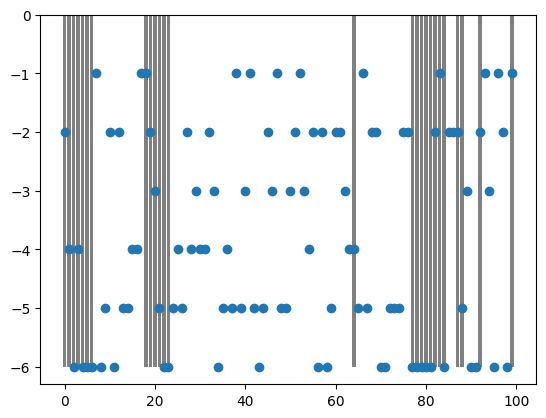

In [15]:

fig, ax = plt.subplots()
x = range(len(rolls))
ax.bar(x, [-6 if i==1 else 0 for i in states], color="grey")
ax.scatter(x, [-i-1 for i in rolls])

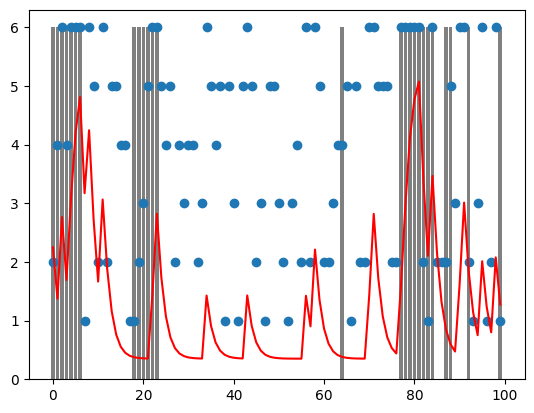

In [23]:





def forward_algorithm(observations):
    """
    Implement the Forward algorithm for HMM with given probabilities.
    """
    
    
    
    alpha = np.zeros((T, N))
    
    # Initialize the first step
      # Assume equal probability of starting fair or unfair
    alpha[0] = initial_probs * emission_matrix[:, observations[0] ]
    
    # Normalize
    alpha[0] /= np.sum(alpha[0])
    
    # Forward pass
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1] * transition_matrix[:, j]) * emission_matrix[j, observations[t] ]
        
        # Normalize
        alpha[t] /= np.sum(alpha[t])
    
    return alpha

# Run Forward algorithm
alpha = forward_algorithm(rolls)

fig, ax = plt.subplots()
x = range(len(rolls))
ax.bar(x, [6 if i==1 else 0 for i in states], color="grey")
ax.scatter(x, [i+1 for i in rolls])
ax.plot(x, alpha[:, 1]*6, color="red", label="Unfair state")

# # Calculate the probability of the sequence
# sequence_probability = np.prod(np.sum(alpha, axis=1))

# # Print results
# print("Given probabilities for fair die:", FAIR_PROBS)
# print("Given probabilities for unfair die:", UNFAIR_PROBS)
# print(f"Probability of staying in fair state: {P_STAY_FAIR:.4f}")
# print(f"Probability of staying in unfair state: {P_STAY_UNFAIR:.4f}")

# print(f"\nProbability of the observed sequence: {sequence_probability:.6e}")

# print("\nDetailed roll analysis:")
# for i, (roll, probs) in enumerate(zip(rolls, alpha), 1):
#     fair_prob, unfair_prob = probs
#     likely_state = "Fair" if fair_prob > unfair_prob else "Unfair"
#     print(f"Roll {i}: {roll} (P(Fair) = {fair_prob:.4f}, P(Unfair) = {unfair_prob:.4f}, More likely: {likely_state})")

# # Calculate the average probability of being in the unfair state
# avg_unfair_prob = np.mean(alpha[:, 1])
# print(f"\nAverage probability of being in the unfair state: {avg_unfair_prob:.4f}")

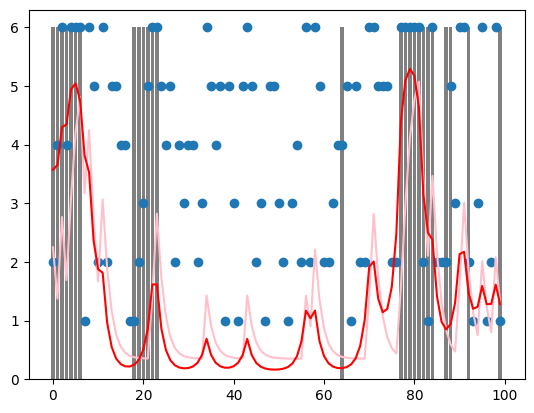

In [25]:
def forward_backward_smoothing(observations, transition_matrix, emission_matrix, initial_probs):
    T = len(observations)
    N = len(initial_probs)
    
    # Forward pass
    alpha = np.zeros((T, N))
    alpha[0] = initial_probs * emission_matrix[:, observations[0]]
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1] * transition_matrix[:, j]) * emission_matrix[j, observations[t]]
        alpha[t] /= np.sum(alpha[t])  # Normalize to prevent underflow
    
    # Backward pass
    beta = np.zeros((T, N))
    beta[-1] = 1
    for t in range(T-2, -1, -1):
        for j in range(N):
            beta[t, j] = np.sum(transition_matrix[j, :] * emission_matrix[:, observations[t+1]] * beta[t+1, :])
        beta[t] /= np.sum(beta[t])  # Normalize to prevent underflow
    
    # Smoothing
    smoothed_probs = np.zeros((T, N))
    for t in range(T):
        smoothed_probs[t] = alpha[t] * beta[t]
        smoothed_probs[t] /= np.sum(smoothed_probs[t])  # Normalize
    
    return smoothed_probs


smoothed_probs = forward_backward_smoothing(rolls, transition_matrix, emission_matrix, initial_probs)

fig, ax = plt.subplots()
x = range(len(rolls))
ax.bar(x, [6 if i==1 else 0 for i in states], color="grey")
ax.scatter(x, [i+1 for i in rolls])
ax.plot(x, alpha[:, 1]*6, color="pink", label="Unfair state")
ax.plot(x, smoothed_probs[:,1]*6, color="red", label="Unfair state")